In [2]:
import torch
import numpy as np
from dataset import Animal10
import torchvision.transforms as tf
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from itertools import cycle

In [3]:
transforms = tf.Compose([
    tf.ToTensor(),
    tf.Resize((224,224)),
    # tf.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    tf.RandomHorizontalFlip(),
    # v2.CutMix(alpha=1,num_classes=10),
])

In [155]:
dataset = Animal10(False,transform=transforms)
data_loader = DataLoader(dataset, 4, True)
cut_mix = v2.CutMix(alpha=1., num_classes=10)

tensor([0.0000, 0.3086, 0.6914, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


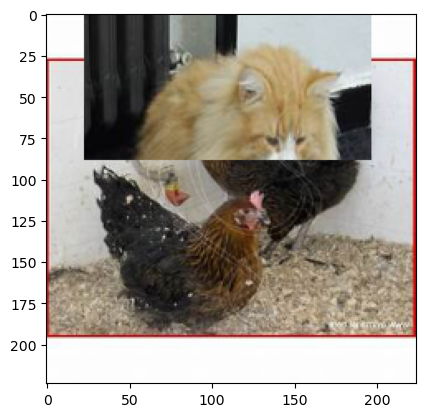

In [156]:
img,label = next(iter(data_loader))
new_img, label = cut_mix(img,label)
img_p = img.permute(0,2,3,1)
new_img_p = new_img.permute(0,2,3,1)
plt.imshow(new_img_p[0])
print(label[0])


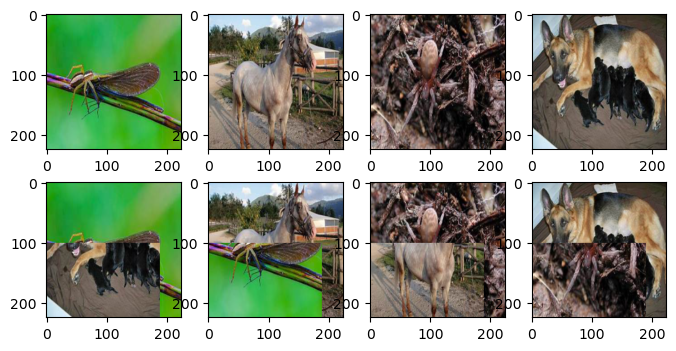

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4633, 0.0000, 0.0000, 0.0000, 0.5367,
        0.0000])


In [60]:
plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(img_p[i])
for i in range(4):
    plt.subplot(2,4,i+5)
    plt.imshow(new_img_p[i])
# for i in range(4):
#     ax[i].imshow(img_p[i])
# plt.imshow(img_p[0])
# plt.imshow(new_img_p[0])
plt.show()
print(label[0])

In [268]:
class grid_cut_mix():
    #grid_type is in ['grid','horizontal', 'vertical']
    #현재 버전은 dataset 이미지의 해상도가 동일할때 적용 가능
    #v2. p 파라메터 제거, grid cutmix 알고리즘 변경, 배치 내에서 grid cutmix 진행
    def __init__(self, num_classes,shape:list,max_grid=6,grid_type='grid'):
        self.max_grid = max_grid
        self.grid_type = grid_type
        self.num_classes = num_classes
        self.shape=shape
        if len(shape) != 2:
            raise ValueError("2차원 배열만 사용 가능합니다.")
        if grid_type not in ['grid','horizontal','vertical']:
            raise ValueError("grid type이 허용되지 않은 종류입니다.")
    def __call__(self,img,label):
        #1/2~ 1/4비율로 섞기
        ratio = np.random.randint(2,4)
        grid = np.random.randint(1,self.max_grid+1)
        true_idx = np.random.randint(ratio)
        if self.grid_type =='horizontal':
            horizontal = torch.zeros(ratio).bool()
            horizontal[true_idx] = True
            horizontal = horizontal.repeat_interleave(grid)
            horizontal = horizontal.repeat((self.shape[1]+2*grid-1)//(2*grid))[:self.shape[1]].view(-1,1).repeat(1,self.shape[1])
            slice_map = horizontal
        elif self.grid_type == 'vertical':
            vertical = torch.zeros(ratio).bool()
            vertical[true_idx] = True
            vertical = vertical.repeat_interleave(grid)
            vertical = vertical.repeat((self.shape[1]+2*grid-1)//(2*grid))[:self.shape[1]].view(1,-1).repeat(self.shape[0],1)
            slice_map = vertical
        elif self.grid_type == 'grid':
            slice_map = torch.zeros(ratio*ratio).bool()
            rand_true = torch.randperm(ratio*ratio)[:ratio]
            slice_map[rand_true] = True
            slice_map = slice_map.reshape(ratio,ratio)
            slice_map = slice_map.repeat_interleave(grid,1).repeat_interleave(grid,0)
            slice_map = slice_map.repeat((self.shape[1]+2*grid-1)//(2*grid),(self.shape[1]+2*grid-1)//(2*grid))[:self.shape[0],:self.shape[1]]
        slice_map = slice_map.repeat(3,1,1)
        shuffle_idx = torch.randperm(img.shape[0])
        label = torch.nn.functional.one_hot(label,self.num_classes).float()
        shuffle_label = label.clone()
        shuffle_label = shuffle_label/ratio
        shuffle_label += label[shuffle_idx]*(1-1/ratio)
        shuffle_img = img.clone()
        shuffle_img[:,slice_map] = img[shuffle_idx][:,slice_map]
        return shuffle_img, shuffle_label
class grid_cut_mix_v3():
    #grid_type is in ['grid','horizontal', 'vertical']
    #현재 버전은 dataset 이미지의 해상도가 동일할때 적용 가능
    #v3. p 파라메터 제거, random scale grid 제거
    def __init__(self, num_classes,shape:list,grid=6,grid_type='grid'):
        self.grid = grid
        self.grid_type = grid_type
        self.num_classes = num_classes
        self.shape=shape
        if len(shape) != 2:
            raise ValueError("2차원 배열만 사용 가능합니다.")
        if grid_type not in ['grid','horizontal','vertical']:
            raise ValueError("grid type이 허용되지 않은 종류입니다.")
    def __call__(self,img,label):
        #1/2~ 1/4비율로 섞기
        ratio = np.random.randint(2,4)
        true_idx = np.random.randint(ratio)
        grid = self.grid
        if self.grid_type =='horizontal' :
            horizontal = torch.zeros(ratio).bool()
            horizontal[true_idx] = True
            horizontal = horizontal.repeat_interleave(grid)
            horizontal = horizontal.repeat((self.shape[1]+2*grid-1)//(2*grid))[:self.shape[1]].view(-1,1).repeat(1,self.shape[1])
            slice_map = horizontal
        elif self.grid_type == 'vertical':
            vertical = torch.zeros(ratio).bool()
            vertical[true_idx] = True
            vertical = vertical.repeat_interleave(grid)
            vertical = vertical.repeat((self.shape[1]+2*grid-1)//(2*grid))[:self.shape[1]].view(1,-1).repeat(self.shape[0],1)
            slice_map = vertical
        elif self.grid_type == 'grid':
            slice_map = torch.zeros(ratio*ratio).bool()
            rand_true = torch.randperm(ratio*ratio)[:ratio]
            slice_map[rand_true] = True
            slice_map = slice_map.reshape(ratio,ratio)
            slice_map = slice_map.repeat_interleave(grid,1).repeat_interleave(grid,0)
            slice_map = slice_map.repeat((self.shape[1]+2*grid-1)//(2*grid),(self.shape[1]+2*grid-1)//(2*grid))[:self.shape[0],:self.shape[1]]
        slice_map = slice_map.repeat(3,1,1)
        shuffle_idx = torch.randperm(img.shape[0])
        label = torch.nn.functional.one_hot(label,self.num_classes).float()
        shuffle_label = label.clone()
        shuffle_label = shuffle_label/ratio
        shuffle_label += label[shuffle_idx]*(1-1/ratio)
        shuffle_img = img.clone()
        shuffle_img[:,slice_map] = img[shuffle_idx][:,slice_map]
        return shuffle_img, shuffle_label


In [308]:
sample_loader = DataLoader(dataset,batch_size=4,shuffle=True)

gcm = grid_cut_mix_v3(10,[224,224],grid=56,grid_type='grid')
# gcm.slice_map.float()

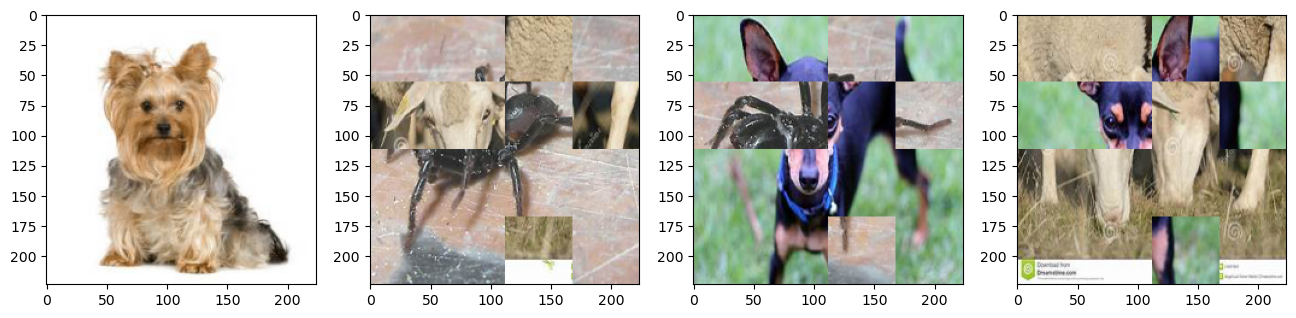

In [316]:
img,label = next(iter(data_loader))
new_img,label = gcm(img,label)
img_p = img.permute(0,2,3,1)
new_img_p = new_img.permute(0,2,3,1)
idx=1
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(new_img_p[i])
# plt.imshow(new_img_p[idx])
# print(label[idx])

In [222]:
test = cycle(sample_loader)
for i in range(5000):
    print(i)
    next(test)

0
1
2
3
4
5
6
7
8
9
10


c:\Users\mg352\anaconda3\envs\ML_cuda2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
2